In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'cmu serif'

page_width = 6.75 # aistats width

In [133]:
ds_name = 'cifar10' #'gtsrb' #'cifar10'

In [134]:
results_path = f'../runs_00_final/{ds_name}/softmax'

In [135]:
l2d_type_lst = ['single', 'pop']
p_out_lst = [0.1,0.2,0.4,0.6,0.8,0.95]
seed_lst = [1071,3918,4420,5251,6637]
metrics_lst = ['cov', 'sys_acc', 'exp_acc', 'clf_acc', 'exp_acc_alone', 'clf_acc_alone', 'val_loss']

results = {}
for l2d_type in l2d_type_lst:
    results[l2d_type] = {}
    metrics_all = {metric:[[] for _ in range(len(p_out_lst))] for metric in metrics_lst}

    for ii,p_out in enumerate(p_out_lst):
        for seed in seed_lst:
            fn = 'eval1.0.log' #'eval.log'
            fn_path = os.path.join(results_path, f'l2d_{l2d_type}', f'p{p_out}_seed{seed}', fn)

            try:
                line = open(fn_path).readline().rstrip()
            except FileNotFoundError:
                print(fn_path)
            else:
                line_split_grp = [line.split()[i:i+2] for i in range(0, len(line.split()),2)]
                for [metric,val] in line_split_grp:
                    if metric=='cov':
                        cov = val.split('/')
                        metrics_all[metric][ii].append(int(cov[0])/int(cov[1]))
                    else:
                        metrics_all[metric][ii].append(float(val))

    for metric, vals in metrics_all.items():
        results[l2d_type][metric] = np.vstack(vals)

In [136]:
c_red = mpl.colormaps['Set1'](0)
c_blue = mpl.colormaps['Set1'](1)

In [137]:
metrics_to_text = {
    'cov':'Coverage',
    'sys_acc': 'System accuracy (\%)',
    'exp_acc': 'Expert accuracy\non deferred examples (\%)',
    'clf_acc': 'Classifier accuracy\n on non-deferred examples',
    'clf_acc_alone': 'Classifier accuracy\n on all examples',
    'val_loss': 'Test loss'
}

In [138]:
l2d_type_to_text = {
    'single': 'Single-expert',
    'pop': 'Population',
}

In [139]:
dataset_to_yticks_expacc = {
    'cifar10' : [20,40,60,80,100]
}

dataset_to_yticks_sysacc = {
    'cifar10' : np.arange(86,99,4),
    'gtsrb' : [94,96,98,100]
}

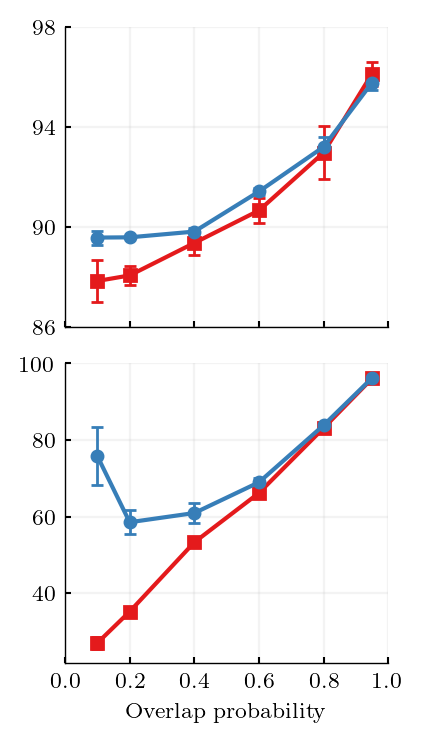

In [141]:
show_ylabels = False
fig_w = 2.25 if show_ylabels else 2.0

fig,axs = plt.subplots(2,1,figsize=(fig_w,3.6), constrained_layout=True)

metric_to_col = {'single':c_red,'pop':c_blue}
metric_to_marker = {'single':'s-','pop':'o-'}
errbar_args={'capsize':2, 'markersize':4, 'elinewidth':1, 'capthick':1, 'lw':1.5} # 'fmt':'o-'

fs_ax_lbl=8
fs_ax_ticks = 8
fs_ax_title = 8

for ax,metric in zip(axs,['sys_acc','exp_acc']):
    for l2d_type in l2d_type_lst:
        metric_mean = np.mean(results[l2d_type][metric], axis=1)
        metric_std = np.std(results[l2d_type][metric], axis=1)
        overlap_prob = np.array(p_out_lst)
        ax.errorbar(overlap_prob, metric_mean, yerr=metric_std, label=l2d_type_to_text[l2d_type], \
                    c=metric_to_col[l2d_type], fmt=metric_to_marker[l2d_type], **errbar_args)
    ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
    
    if show_ylabels:
        ax.set_ylabel(metrics_to_text[metric], fontsize=fs_ax_lbl)
    ax.grid(True, alpha=0.15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(direction='in', labelsize=fs_ax_ticks,length=2., width=0.75)
    [x.set_linewidth(.5) for x in ax.spines.values()]

axs[0].tick_params(labelbottom=False)    
axs[1].set_xlabel('Overlap probability', fontsize=fs_ax_lbl)
# axs[1].set_yticks(dataset_to_yticks_expacc[ds_name])
axs[0].set_yticks(dataset_to_yticks_sysacc[ds_name])
if show_ylabels:
    leg = axs[0].legend(fontsize=fs_ax_title,frameon=False);
    # leg.get_frame().set_linewidth(0.5)

# fig.savefig(f'exp_{ds_name}.pdf', dpi=600, facecolor='white', bbox_inches='tight', pad_inches=0.01)